This code is intended to run BGM simulations for a single pointing to simulate the stellar bycatch captured.
This calculator provides the same inputs as described in Mason et. al. (2025) to enable a more complete estimation of the 
number & spectral type of stellar systems captured within SETI surveys, and constraining the limits on the prevelance of 
high-duty-cycle technosignatures. 

Note: It is necessary for you to create an account on https://model.obs-besancon.fr/ before running this code. 
Please also download galmod_client.py - written by Raphael Melior to launch simulations for the BGM web service and Gravpot web service.

Essential:
    
1. Input parameters from user - coordinates, field of view, SEFD, etc.
2. Run BGM simulation for calculated solid angle
3. Open results from simulation, filter for stars within FoV, and save table as output file. 
   We plot the stellar bycatch within the FoV, colour coded by spectral type.

Optional:
    
4. Plot stellar bycatch's distance against absolute magnitude
5. For increasing shells of EIRP, we calculate the number of stars per shell and corresponding transmitter rate.
6. We seperate the bycatch population by spectral & luminosity type, and calculate the prevelance per spectral class 
   for increasing shells of distance. We plot a HR diagram for the bycatch sample. 
7. We estimate the prevelance due to the total stellar bycatch up up to 25kpc. 

In [1]:
from astropy.io import ascii
import matplotlib.pyplot as plt
from astroquery.gaia import Gaia
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic, FK4, FK5
from astroquery.vizier import Vizier
import astropy.coordinates as coord
from astropy.io.votable import parse
import numpy as np
from astropy.table import Table, vstack
import mpl_scatter_density
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap
Vizier.ROW_LIMIT = -1

In [2]:
# Inputs from user - please specify:
coords = ['16h02m32.16s', '-11d00m43.2s']   #    the coordinates of the pointing (in RA & Dec)
fov = 5                                     #    the field of view (in arcmins), 
sefd = 34                                   #    the SEFD of the telescope (in Jy)
spec_res = 1                                #    the spectral resolution (in Hz)
freq_range = [2.60, 3.45]                   #    the bandwidth of observations [min freq, max freq] (in GHz)
snr_threshold = 10                          #    the signal to noise threshold (e.g. 3 sigma, 5 sigma, 10 sigma)
t_obs = 5*60                                #    the length of observations (in seconds)
beta = 16.5                                 #    dechirping efficiency (in %)

# It is necessary to provide your username and password for your BGM account.
username = 
password = 

# Optional Inputs - For a standard SETI survey, it is unlikely to need  to be changed
n_pol = 1         #    the number of polarisations searched
epoch = 2000      #    the reference frame epoch for RA and Dec of simulated stars
                  #    Note - if changing the epoch, you will need to change 'RA' & 'DEC' names from BGM simulation later

In [3]:
# Outputs - a table of the simulated bycatch will be saved to your computer. 
filename = 'BGM_FoV_1.txt'        #    If you wish, you can modify the name of this saved file.

In [4]:
#Calculations needed for code - please don't change!
c = SkyCoord(coords[0], coords[1], frame=ICRS)
coords_deg = (c.ra.deg, c.dec.deg)
bandwidth = freq_range[1] - freq_range[0]
central_freq = freq_range[0] + (0.5 * bandwidth)
fov = fov / 60                   # deg
solid_angle = (fov + 0.1*fov)**2
beta = beta / 100

In [5]:
def run_job(coords1, coords2, solid_angle):
    # Run BGM simulations for a given direction and solid angle.
    %run galmod_client.py --url "https://model.obs-besancon.fr/ws/" --user $username --pass $password --create -p KLEH 2 -p Coor1_min $coords1 -p Coor2_min $coords2 -p Coor1_max $coords1 -p Coor2_max $coords2 -p Dist_max 25.00 -p SOLI $solid_angle -p eq1 $epoch -p AbsMag_min -14 -p AbsMag_max 30 -p KLEC 10 -p ref_filter G -p acol G-V,G-I,I-J,J-K  -p band_max 99.,99.,99.,99.,99.,99.,99.,99.,99.,99.,99. -p band_step 1.,1.,1.,1.,1.,1.,1.,1.,1.,1.,1. -p errBand_A 0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02 -p errBand_B 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0. -p errBand_C 0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0. -p band_min "-99., -99., -99., -99., -99., -99., -99., -99., -99., -99., -99." --run
    idJob = int(job.find('uws:jobId', XML_NS).text)
    return(idJob)

In [6]:
def gauss(x, fov):
    # Gaussian function, applied with respect to correct the EIRP of stars that are off-centred in the field of view. 
    sig = (0.5 * fov) / (2*np.sqrt(2*np.log(2)))
    y = np.exp(-(x)**2 / (2*(sig**2)))
    return(y)

In [7]:
def read_and_save(JobID, coords1, coords2, radius):
    # Opens the results from BGM, restricts sample to within the field of view and saves table of stellar parameters for the
    # bycatch population. Jobs will be cleared periodically from BGM's web portal, so you may wish to save the complete 
    # simulation directly from  https://model.obs-besancon.fr/
    
    %run galmod_client.py --url "https://model.obs-besancon.fr/ws/" --user $username --pass $password --job $JobID
    uws = UWS(args.url, (args.user, passwd))
    results = job.find('uws:results', XML_NS)
    if results is not None:
        a = 0
        for res in results.findall('uws:result', XML_NS):
            if a == 0:
                output = res.get('{http://www.w3.org/1999/xlink}href')
            if a == 1:
                output_head = res.get('{http://www.w3.org/1999/xlink}href')
            a = a + 1
    data = ascii.read(output)
    print(len(data))
    c = np.where(((data['RAJ2000'] - coords1)**2 + (data['DECJ2000'] - coords2)**2) < radius**2)
    c = c[0]
    print('BGM no. of stars ', len(c))
    data = data[c]
    ascii.write(data, filename, overwrite = True)
    
    # Plot the stellar bycatch population within the field of view, highlighting the different spectral types simulated.
    markers = ['D', '^', '+', '1', '.', 'x']
    luminosity = np.arange(1, 7, 1)
    luminosity_name = ['Supergiants', 'Bright Giants', 'Normal Giants', 'Subgiants', 'Main Sequence', 'White Dwarfs']

    fig, ax = plt.subplots(figsize = (7, 6))
    for i in range(len(luminosity)):
        f = np.where(luminosity[i] == data['CL'])
        f = f[0]
        cax = plt.scatter(data['RAJ2000'][f], data['DECJ2000'][f], marker = markers[i], c = data['Typ'][f], 
                    label = luminosity_name[i], vmin = 1.1, vmax = 9.3)
    circle1 = plt.Circle((coords_deg[0], coords_deg[1]), fov / 2, color='k', fill = False, alpha = 0.5)
    ax.add_patch(circle1)
    cbar = fig.colorbar(cax, ticks=np.arange(1, 10, 1),
                        format=mticker.FixedFormatter(['O', 'B', 'A', 'F', 'G', 'K', 'M', 'AGB', 'WD']), pad = 0.1)
    cbar.set_label('Spectral Class') #, size = 15)
    box = ax.get_position()
    ax.set_position([box.x0, box.y0 + box.height*0.2, box.width, box.height*0.8])
    ax.legend(title = 'Luminosity Type', loc = 'upper center', bbox_to_anchor = (0.5, -0.15), ncol = 3)
    plt.xticks(np.arange(240.60, 240.70, 0.02))#, size = 15)
    #plt.yticks(np.arange(-10.98, 11.06, 0.02), size = 15)
    plt.xlabel('Right Ascension / deg') #, size = 15)
    plt.ylabel('Declination / deg') #, size = 15)
    plt.show()

    # Generate Results Table - labelling spectral and luminosity classes correctly.
    names = np.append([], np.repeat('', len(data)))
    classes = np.arange(1, 10, 1)
    class_name = ['O', 'B', 'A', 'F', 'G', 'K', 'M', 'AGB', 'WD']
    cl = data['Typ'].astype(int)
    subs = [0, 1, 4]
    agb_sub = ['carb','oxy','oth']
    wd_sub = ['DA', 'DB', 'oth']

    for i in range(len(classes)):
        v = np.where(cl == classes[i])
        v = v[0]
        if len(v) > 0:
            cl_sub = ((data['Typ'][v] - classes[i]) * 10).astype(int)
            if classes[i] < 8:
                for j in range(10):
                    v2 = np.where(cl_sub == j)
                    v2 = v2[0]
                    n = ''.join((class_name[i], str(j)))
                    names[v[v2]] = n
            elif classes[i] == 8:
                for j in range(len(subs)):
                    v2 = np.where(cl_sub == subs[j])
                    v2 = v2[0]
                    n = ' '.join((class_name[i], agb_sub[j]))
                    names[v[v2]] = n
            elif classes[i] == 9:
                for j in range(len(subs)):
                    v2 = np.where(cl_sub == subs[j])
                    v2 = v2[0]
                    n = ' '.join((class_name[i], wd_sub[j]))
                    names[v[v2]] = n


    lum_names = np.append([], np.repeat('', len(data)))
    for i in range(len(luminosity)):
        v = np.where(data['CL'] == luminosity[i])
        v = v[0]
        lum_names[v] = luminosity_name[i]

    t = Table(names = ('RA', 'DEC', 'Dist_pc', 'M_V', 'm_G', 'G-V', 'Age', 'Mass', 'Teff_K', 'Spectral Class',
                       'Luminosity Class', 'EIRP_W'), #'mux_arcsec', 'muy_arcsec',
              dtype = ('f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'S20', 'S20', 'f4')) #, 'f4', 'f4'))
    offset = (data['RAJ2000'] - coords1)**2 + (data['DECJ2000'] - coords2)**2
    resp = gauss(offset, fov)
    eirp = 4 * np.pi * (data['Dist'] * 10**3 *3.086*10**16)**2 * snr_threshold * sefd*10**(-26) * np.sqrt(spec_res / (n_pol * t_obs))
    eirp_corrected = eirp / resp
    eirp_lower = eirp_corrected / beta

    add = Table({'RA': data['RAJ2000'], 'DEC': data['DECJ2000'], 'Dist_pc': data['Dist']*10**3, 
                 'M_V': data['Mv'], 'm_G': data['G'], 'G-V': data['G-V'], 'Age': data['Age'], 'Mass': data['Mass'], 'Teff_K': data['Teff'],
                 'Spectral Class' : names, 'Luminosity Class': lum_names, 'EIRP_W': eirp_corrected, 'EIRP_smear_W': eirp_lower},  #'mux_arcsec': data['mux'], 'muy_arcsec': data['muy'],
            dtype = ('f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'f4', 'S20', 'S20', 'f4', 'f4')) #, 'f4', 'f4'))
    t = vstack([t, add])
    return(t)

In [8]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
    # Plots the stellar bycatch sample, comparing the distances to stars as well as the absolute magnitudes. 
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax.scatter(x, y, marker = '.', s = 10, color = 'k', label = 'BGM')
    ax.invert_yaxis()
    ax.set_xlabel('Distance / kpc')
    ax.set_ylabel('Absolute Magnitude')
    ax.legend()

    binwidth = 0.25
    binsx = np.arange(np.min(x) - 1, np.max(x) + 1, binwidth)
    ax_histx.hist(x, bins=binsx, color = 'k')
    ax_histx.set_ylabel('n')
    
    binsy = np.arange(np.min(y) - 1, np.max(y) + 1, binwidth)
    ax_histy.hist(y, bins=binsy, color = 'k', orientation='horizontal')
    ax_histy.invert_yaxis()
    ax_histy.set_xlabel('n')
    return()

In [9]:
def results_by_eirp_shells(shells, data, vrel):
    # Creates table of the total number of stars for increasing EIRP_min shells. 
    table = Table(names=('log(EIRP)', 'Total No of Stars', 'Transmitter Rate'), dtype=('f8', 'i4', 'f8'))
    total = 0
    for i in range(len(shells) - 1):
        a = np.where((shells[i] < np.log10(data['EIRP_W'])) & (np.log10(data['EIRP_W']) <= shells[i+1]))
        size = len(a[0])
        total = total + size
        if size > 0:
            tr = 1 / (size*vrel)
        else:
            tr = 0
        row = [shells[i+1], total, tr]
        table.add_row(row)
    print(table)
    
    # We plot transmitter rate against EIRP, comparing against the typical EIRP for an Arecibo-like transmitter (10^13W)
    # and a transmitter of power equivalent to a Type I Kardashev cicvilisation (10^17W). We also compare our results 
    # against the currently unexplored parameter space (bottom left, blow 'terra incognito' line in black.)
    
    plt.figure(figsize = (6, 6))
    my_labels = {"x1" : "Barts Stars", "x2" : "BGM Stars"}
    plt.scatter(table['log(EIRP)'], np.log10(table['Transmitter Rate']), marker = '.', color = 'k')
    line = ((10.5, 21.7), (-2, -9))
    plt.plot(line[0], line[1], color = 'k', linestyle = 'dotted')
    plt.axis([10.5, 24.5, -9, 3.5])
    plt.axvline(13, color = 'y', linestyle = 'dotted')
    plt.axvline(17, color = 'y', linestyle = 'dotted')
    plt.ylabel('log(Transmitter Rate)')
    plt.xlabel('log(EIRP / W)')
    plt.show()    
    return(table)

In [10]:
def results_by_MK_class(d):
    # For each spectral class & luminosity type, we calculate the number of stars and estimate the prevelance of high-duty-
    # cycle technosignatures, for shells of increasing distance up to 10kpc. The prevelance is estimated using the 'rule of
    # three' and the associated error is related to the poisson error in number of stars. 
    
    spec = ['O', 'B', 'A', 'F', 'G', 'K', 'M', 'AGB']
    spec_wd = ['WD DA', 'WD DB']
    dist = np.append([500, 1000], np.arange(5000, 15000, 5000))
    tab = []
    tab = Table(names=('Type', 'Class', '0.5kpc', 'prev 0.5', 'err prev 0.5', '1kpc', 'prev 1', 'err prev 1',
                       '5kpc', 'prev 5', 'err prev 5', '10kpc', 'prev 10', 'err prev 10'), 
                dtype=('S20','S2','i4','f4','f4','i4','f4','f4','i4','f4','f4','i4','f4','f4'))
    names = ['Supergiants', 'Bright Giants', 'Normal Giants', 'Subgiants', 'Main Sequence', 'White Dwarfs']

    for i in range(len(names)):
        m = np.where(d['Luminosity Class'] == names[i])
        m = m[0]
        if names[i] == 'White Dwarfs':
            for j in range(len(spec_wd)):
                h = []
                for k in range(len(m)):
                    if spec_wd[j] in d['Spectral Class'][m[k]]:
                        h = np.append(h, int(m[k]))
                if len(h) > 0:
                    row = np.append([], (names[i], spec_wd[j]))
                    h = h.astype(int)
                    for l in range(len(dist)):
                        h1 = np.where(d['Dist_pc'][h] <= dist[l])
                        h1 = len(h1[0])
                        if h1 > 0:
                            p = 3 / h1
                            err_p = (3 * np.sqrt(h1)) / h1**2
                            if p >= 1:
                                p = 1
                                err_p = 1
                            p = p * 100
                            err_p = err_p * 100
                            row = np.append(row, h1)
                            row = np.append(row, (p, err_p))
                        else:
                            row = np.append(row, (0, 0, 0))
                    tab.add_row(row)
        else:
            for j in range(len(spec)):
                h = []
                row = []
                for k in range(len(m)):
                    if spec[j] in d['Spectral Class'][m[k]]:
                        h = np.append(h, int(m[k]))
                if len(h) > 0:
                    row = np.append([], (names[i], spec[j]))
                    h = h.astype(int)
                    for l in range(len(dist)):
                        h1 = np.where(d['Dist_pc'][h] <= dist[l])
                        h1 = len(h1[0])
                        if h1 > 0:
                            p = 3 / h1
                            err_p = (3 * np.sqrt(h1)) / h1**2
                            if p >= 1:
                                p = 1
                                err_p = 1
                            p = p * 100
                            err_p = err_p * 100
                            row = np.append(row, h1)
                            row = np.append(row, (p, err_p))
                        else:
                            row = np.append(row, (0, 0, 0))
                    tab.add_row(row)
        
    #Plot HR Diagram for stellar bycatch sample, comparing against proposed transmitter thresholds and the region of 
    # unexplored EIRP-Transitter Rate parameter space, known as 'terra incognito'.
    white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
        (0, 'none'),
        (1e-30, '#440053'),
        (0.2, '#404388'),
        (0.4, '#2a788e'),
        (0.6, '#21a784'),
        (0.8, '#78d151'),
        (1, '#fde624'),
    ], N=256)

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(d['Teff_K'], d['M_V'], cmap= white_viridis, zorder = 1)#, norm=norm)
    fig.colorbar(density, label='Density')
    ax.invert_xaxis()
    ax.invert_yaxis()
    ax.set_xscale('log')
    ax.axis([3*10**4, 1*10**3, 26, -2])
    ax.set_xlabel('Effective Temperature / K')
    ax.set_ylabel('Absolute Magnitude')
    plt.show()
    return(tab)

In [11]:
def total_prevalence(data, shells):
    # Estimates the prevalence for high-duty-cycle technosignatures, based on the 'rule of three' approximation for null
    # detection from the Poisson distribution. 
    t = Table(names=('Distance', 'No of Stars', 'Cumulative Total', 'Probability'), dtype=('f8', 'i4', 'f8', 'f8'))
    total = 0
    for i in range(len(shells) - 1):
        a = np.where((shells[i] < data) & (data <= shells[i+1]))
        size = len(a[0])
        total = total + size
        p = 3 / total
        row = [shells [i+1], size, total, p]
        t.add_row(row)
            
    plt.figure()
    plt.scatter(t['Distance'], t['Probability'], marker = '.', c = 'k')
    plt.yscale('log')
    plt.xlabel('Distance / kpc')
    plt.ylabel('Prevalence of Technosignatures')
    plt.show()
    return(t)

In [12]:
# Run BGM simulations for a given direction and solid angle.

job_id = run_job(coords_deg[0], coords_deg[1], solid_angle)

Creating job
SERVER RESPONSE : Job 212188 created
SERVER RESPONSE : Job 212188 setting parameters completed
SERVER RESPONSE : Job 212188 submitted for computation
id                :212188
owner             :louisamason11
phase             :QUEUED
startTime         :
endTime           :
destruction       :2025-10-24T14:13:31+00:00
executionDuration :86400

Parameters ........
version           :m1612
KLEH              :2
Dist_min          :0.00
Coor1_min         :240.63400000000001
Coor2_min         :-11.012
Dist_max          :25.00
Coor1_max         :240.63400000000001
Coor2_max         :-11.012
Dist_step         :2.00
Coor1_step        :1.00
Coor2_step        :1.00
DLR0              :0
SOLI              :0.008402777777777776
eq1               :2000
resolution        :0.1
KLEA              :1
KLEB              :3
KLEG              :1
NMAG              :0
kabs1             :1
kord1             :2
KLEI              :0
sendmail          :1
KLEC              :10
ref_filter        :G
acol 

Expect a delay between running a job, and then being able to read and save it.

Depending on the size of the simulation, you will need to wait a couple of minutes before running 'read_and_save'

(You can expect an email from BGM to notify you when the simulation is complete, or log into 
 https://model.obs-besancon.fr/ to check the simulation's progress)

id                :212188
owner             :louisamason11
phase             :COMPLETED
startTime         :2025-10-17T14:13:35+00:00
endTime           :2025-10-17T14:13:40+00:00
destruction       :2025-10-24T14:13:31+00:00
executionDuration :86400

Parameters ........
version           :m1612
KLEH              :2
Dist_min          :0.00
Coor1_min         :240.63400000000001
Coor2_min         :-11.012
Dist_max          :25.00
Coor1_max         :240.63400000000001
Coor2_max         :-11.012
Dist_step         :2.00
Coor1_step        :1.00
Coor2_step        :1.00
DLR0              :0
SOLI              :0.008402777777777776
eq1               :2000
resolution        :0.1
KLEA              :1
KLEB              :3
KLEG              :1
NMAG              :0
kabs1             :1
kord1             :2
KLEI              :0
sendmail          :1
KLEC              :10
ref_filter        :G
acol              :G-V,G-I,I-J,J-K
band_min          :-99., -99., -99., -99., -99., -99., -99., -99., -99., -99., -

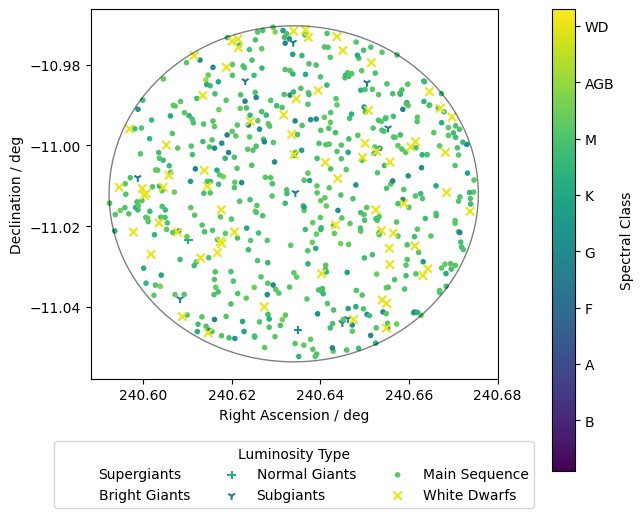

In [15]:
# Opens the results from BGM, restricts sample to within the field of view and saves table of stellar parameters for the
# bycatch population. Jobs will be cleared periodically from BGM's web portal, so you may wish to save the complete 
# simulation directly from  https://model.obs-besancon.fr/

#We then plot the stellar bycatch within the field of view, highlighting the spectral classes and luminosity types. 

bgm_table = read_and_save(idJob, coords_deg[0], coords_deg[1], fov / 2) 

In [16]:
bgm_table

RA,DEC,Dist_pc,M_V,m_G,G-V,Age,Mass,Teff_K,Spectral Class,Luminosity Class,EIRP_W,EIRP_smear_W
float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes20,bytes20,float32,float32
240.62093,-10.997649,314.1,10.44,18.838,0.83,3.9583,0.499,3516.0,M2,Main Sequence,231821870000000.0,1404981000000000.0
240.63174,-10.992443,347.1,17.7,25.541,0.037,9.9614,0.577,2324.0,WD DA,White Dwarfs,283095800000000.0,1715732000000000.0
240.66737,-10.994367,362.0,6.42,14.579,0.242,1.434,0.751,4687.0,K2,Main Sequence,308848180000000.0,1871807000000000.0
240.60388,-11.034929,372.8,17.69,27.903,2.204,4.0289,0.035,2835.0,M6,Main Sequence,327563670000000.0,1985234300000000.0
240.60458,-10.983521,381.9,12.21,21.14,0.898,9.8076,0.202,3323.0,M2,Main Sequence,344166330000000.0,2085856500000000.0
240.60727,-10.990239,565.1,14.38,24.796,1.442,6.0169,0.31,3091.0,M4,Main Sequence,751881900000000.0,4556860000000000.0
240.61748,-11.017745,553.3,10.99,20.718,0.936,1.3925,0.499,3399.0,M2,Main Sequence,719293740000000.0,4359356000000000.0
240.66612,-11.016833,558.6,12.52,22.28,0.886,9.9866,0.207,3422.0,M2,Main Sequence,734334800000000.0,4450513800000000.0
240.64629,-11.040448,581.6,5.91,15.067,0.192,8.469,0.835,5114.0,K0,Main Sequence,795808000000000.0,4823078600000000.0


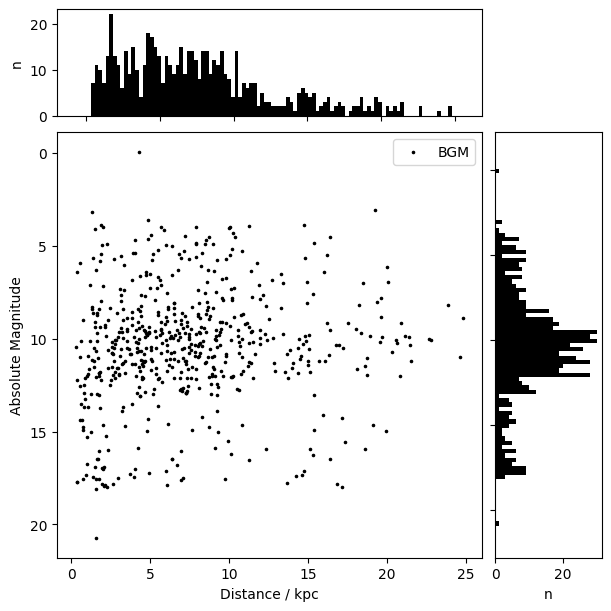

In [17]:
# Plots the stellar bycatch sample, comparing the distances to stars as well as the absolute magnitudes.

fig, axs = plt.subplot_mosaic([['histx', '.'], ['scatter', 'histy']], figsize=(6, 6), width_ratios=(4, 1), 
                              height_ratios=(1, 4), layout='constrained')
scatter_hist(bgm_table['Dist_pc'] / 10**3, bgm_table['M_V'], axs['scatter'], axs['histx'], axs['histy'])
plt.show()

log(EIRP) Total No of Stars   Transmitter Rate  
--------- ----------------- --------------------
     15.0                11   0.3235294117647059
     16.0                83   0.0494281045751634
     17.0               291  0.01710972850678733
     18.0               583 0.012187751813053987


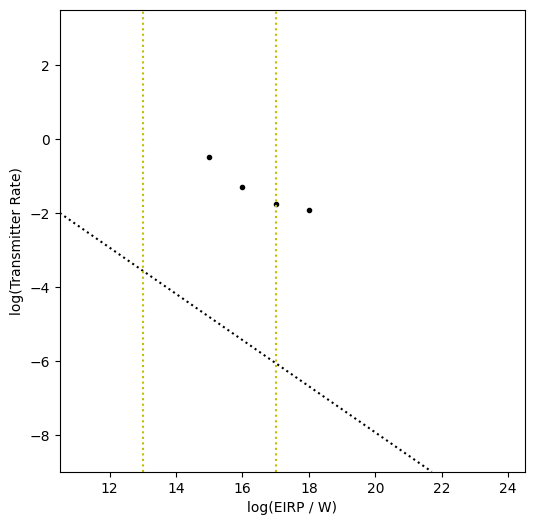

In [18]:
# Creates table of the total number of stars for increasing EIRP_min shellsand estimating the transmitter rate.
# We compare our sample's EIRP-Transmitter Rate against proposed transmitter thresholds (Arecibo-like transmitter, 
# Type I Kardashev civilisation) and unexplored parameter space ('terra incognito')

shells = np.arange(np.floor(np.log10(np.min(bgm_table['EIRP_W']))), np.ceil(np.log10(np.max(bgm_table['EIRP_W']))), 1)
eirp_table = results_by_eirp_shells(shells, bgm_table, bandwidth / central_freq)

C:\Users\cooll\anaconda3\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
C:\Users\cooll\anaconda3\Lib\site-packages\mpl_scatter_density\generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


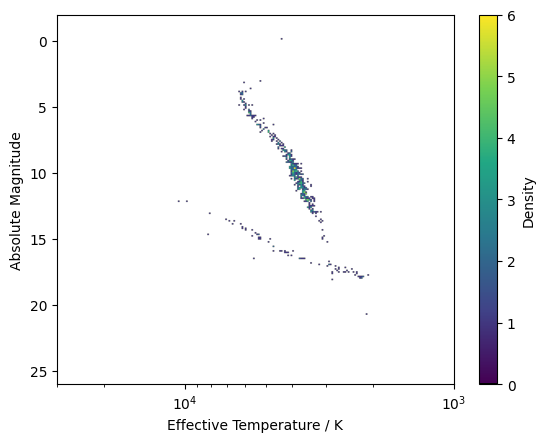

Type,Class,0.5kpc,prev 0.5,err prev 0.5,1kpc,prev 1,err prev 1,5kpc,prev 5,err prev 5,10kpc,prev 10,err prev 10
bytes20,bytes5,int32,float32,float32,int32,float32,float32,int32,float32,float32,int32,float32,float32
Normal Giants,G,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
Normal Giants,K,0,0.0,0.0,0,0.0,0.0,1,100.0,100.0,1,100.0,100.0
Subgiants,F,0,0.0,0.0,0,0.0,0.0,3,100.0,100.0,5,60.0,26.832815
Main Sequence,B,0,0.0,0.0,0,0.0,0.0,1,100.0,100.0,1,100.0,100.0
Main Sequence,A,0,0.0,0.0,0,0.0,0.0,1,100.0,100.0,1,100.0,100.0
Main Sequence,F,0,0.0,0.0,0,0.0,0.0,4,75.0,37.5,15,20.0,5.1639776
Main Sequence,G,0,0.0,0.0,0,0.0,0.0,13,23.076923,6.400387,29,10.344828,1.9209863
Main Sequence,K,1,100.0,100.0,3,100.0,100.0,38,7.894737,1.2806954,100,3.0,0.3
Main Sequence,M,3,100.0,100.0,17,17.647058,4.2800403,131,2.2900763,0.2000849,242,1.2396694,0.079688966


In [19]:
# For each spectral class & luminosity type, we calculate the number of stars and estimate the prevelance of high-duty-
# cycle technosignatures, for shells of increasing distance up to 10kpc. The prevelance is estimated using the 'rule of
# three' and the associated error is related to the poisson error in number of stars.


class_table = results_by_MK_class(bgm_table)
class_table

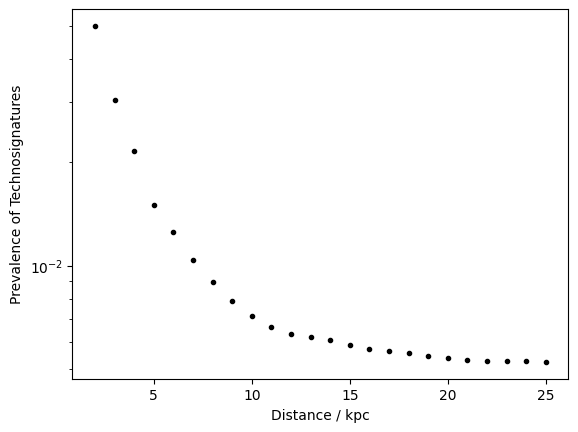

In [20]:
# We estimate the prevalence for high-duty-cycle technosignatures, based on the 'rule of three' approximation for null
# detection from the Poisson distribution.

shells = np.arange(1, 26, 1)
prevalence = total_prevalence(bgm_table['Dist_pc'] / 10**3, shells)